# VIZ FOCUS #

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics

In [2]:
# read in csv
df = pd.read_csv('../datasets/train.csv')
#set to read more columns
pd.options.display.max_columns = 999
#sort columns alpha
df = df.reindex(sorted(df.columns), axis=1)
#drop two outliers 
df.drop([960, 1885], inplace=True)

# CLEANING

In [3]:
#sort null
df.isnull().sum().sort_values()

1st Flr SF            0
MS Zoning             0
MS SubClass           0
Low Qual Fin SF       0
Lot Shape             0
                   ... 
Fireplace Qu       1000
Fence              1649
Alley              1909
Misc Feature       1985
Pool QC            2041
Length: 81, dtype: int64

In [4]:
#replace 14 of 26 ordinal features with NaN to NA as in data dictionary

df = df.fillna({'Pool QC': 'NA',
           'Misc Feature': 'NA',
           'Alley': 'NA',
           'Fence': 'NA',
           'Fireplace Qu': 'NA',
           'Garage Finish': 'NA',
           'Garage Qual': 'NA',
           'Garage Cond': 'NA',
           'Garage Type': 'NA',
           'Bsmt Exposure': 'NA',
           'BsmtFin Type 2': 'NA',
           'BsmtFin Type 1': 'NA',
           'Bsmt Cond': 'NA',
           'Bsmt Qual': 'NA',
           'Mas Vnr Type': 'NA',
           'Electrical': 'NA',
})

In [5]:
df.isnull().sum().sort_values()

1st Flr SF          0
Misc Feature        0
Mas Vnr Type        0
MS Zoning           0
MS SubClass         0
                 ... 
Bsmt Half Bath      2
Bsmt Full Bath      2
Mas Vnr Area       22
Garage Yr Blt     114
Lot Frontage      330
Length: 81, dtype: int64

In [6]:
#replace null values with mean
feat_list = ['Lot Frontage', 'Garage Yr Blt', 'Mas Vnr Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'BsmtFin SF 1', 'Total Bsmt SF', 'Garage Area', 'Garage Cars', 'Bsmt Unf SF', 'BsmtFin SF 2']
for feat in feat_list:
        df[feat].fillna(df[feat].mean(), inplace=True)
#check that null are gone
df.isnull().sum().sum()

0

# EDA

In [7]:
top_15 = df.corr()[['SalePrice']].sort_values(by='SalePrice',ascending=False).head(15).index

Text(0.5, 1.0, 'Features Correlation Heatmap')

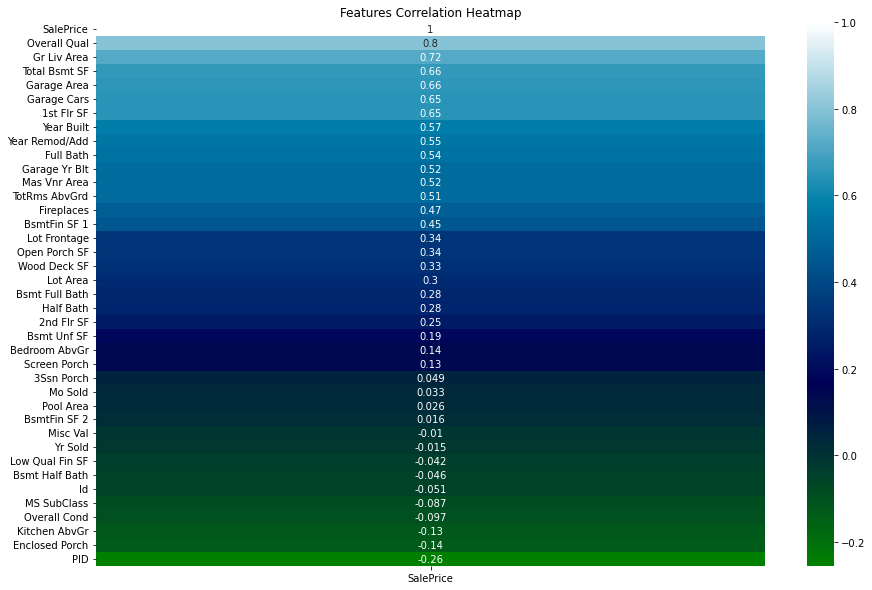

In [8]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap='ocean')
plt.title('Features Correlation Heatmap')
#plt.savefig('./images/ocean corr heatmap');

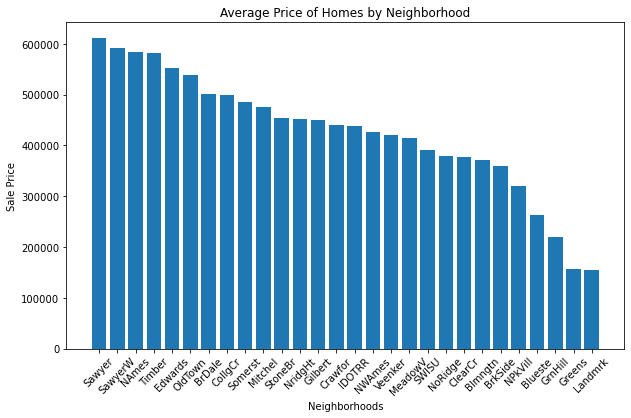

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(df['Neighborhood'], df['SalePrice'].sort_values(ascending=False))
plt.title('Average Price of Homes by Neighborhood')
plt.xlabel('Neighborhoods')
plt.ylabel('Sale Price')
plt.xticks(rotation=45);
#plt.savefig('./images/Price by Neighborhood');

In [10]:
Price_hood = df.loc[:, ['SalePrice', 'Neighborhood']]
Price_hood.sort_values(by='SalePrice')

,SalePrice,Neighborhood
1628,12789,OldTown
183,13100,IDOTRR
1309,34900,IDOTRR
1292,35000,Edwards
1518,35311,IDOTRR
...,...,...
151,556581,StoneBr
1796,582933,NridgHt
1692,584500,NoRidge
1964,591587,StoneBr


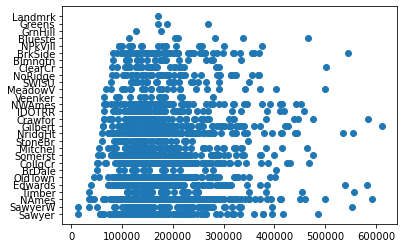

In [11]:
plt.scatter(df['SalePrice'].sort_values(), df['Neighborhood'])

(array([ 42., 525., 816., 350., 168.,  79.,  40.,  16.,   6.,   7.]),
 array([ 12789. ,  72675.8, 132562.6, 192449.4, 252336.2, 312223. ,
        372109.8, 431996.6, 491883.4, 551770.2, 611657. ]),
 <BarContainer object of 10 artists>)

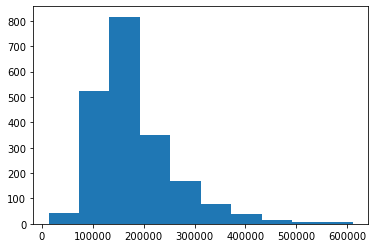

In [12]:
plt.hist(df['SalePrice'])

In [13]:
df['SalePrice'].describe()

count      2049.000000
mean     181479.018058
std       79295.913255
min       12789.000000
25%      129800.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

GET SALE PRICE MEAN AND MEDIAN

In [14]:
df['SalePrice'].mean()

181479.01805758907

In [15]:
df['SalePrice'].median()

162500.0

# FEATURE ENGINEERING

In [16]:
#combine all baths columns
sum_column_2 = df['Full Bath'] + df['Bsmt Full Bath']
sum_column_3 = df['Half Bath'] + df['Bsmt Half Bath']
df['Total Baths'] = sum_column_2 + sum_column_3

In [17]:
#create total Fin SF column
sum_column = df['1st Flr SF'] + df['2nd Flr SF']
sum_column_2 = df['BsmtFin SF 1'] + df['BsmtFin SF 2']
df['Total Fin SF'] = sum_column + sum_column_2
df.head()

,1st Flr SF,2nd Flr SF,3Ssn Porch,Alley,Bedroom AbvGr,Bldg Type,Bsmt Cond,Bsmt Exposure,Bsmt Full Bath,Bsmt Half Bath,Bsmt Qual,Bsmt Unf SF,BsmtFin SF 1,BsmtFin SF 2,BsmtFin Type 1,BsmtFin Type 2,Central Air,Condition 1,Condition 2,Electrical,Enclosed Porch,Exter Cond,Exter Qual,Exterior 1st,Exterior 2nd,Fence,Fireplace Qu,Fireplaces,Foundation,Full Bath,Functional,Garage Area,Garage Cars,Garage Cond,Garage Finish,Garage Qual,Garage Type,Garage Yr Blt,Gr Liv Area,Half Bath,Heating,Heating QC,House Style,Id,Kitchen AbvGr,Kitchen Qual,Land Contour,Land Slope,Lot Area,Lot Config,Lot Frontage,Lot Shape,Low Qual Fin SF,MS SubClass,MS Zoning,Mas Vnr Area,Mas Vnr Type,Misc Feature,Misc Val,Mo Sold,Neighborhood,Open Porch SF,Overall Cond,Overall Qual,PID,Paved Drive,Pool Area,Pool QC,Roof Matl,Roof Style,Sale Type,SalePrice,Screen Porch,Street,TotRms AbvGrd,Total Bsmt SF,Utilities,Wood Deck SF,Year Built,Year Remod/Add,Yr Sold,Total Baths,Total Fin SF
0,725,754,0,NA,3,1Fam,TA,No,0.0,0.0,TA,192.0,533.0,0.0,GLQ,Unf,Y,RRAe,Norm,SBrkr,0,TA,Gd,HdBoard,Plywood,NA,NA,0,CBlock,2,Typ,475.0,2.0,TA,RFn,TA,Attchd,1976.0,1479,1,GasA,Ex,2Story,109,1,Gd,Lvl,Gtl,13517,CulDSac,68.878999,IR1,0,60,RL,289.0,BrkFace,NA,0,3,Sawyer,44,8,6,533352170,Y,0,NA,CompShg,Gable,WD,130500,0,Pave,6,725.0,AllPub,0,1976,2005,2010,3.0,2012.0
1,913,1209,0,NA,4,1Fam,TA,No,1.0,0.0,Gd,276.0,637.0,0.0,GLQ,Unf,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NA,TA,1,PConc,2,Typ,559.0,2.0,TA,RFn,TA,Attchd,1997.0,2122,1,GasA,Ex,2Story,544,1,Gd,Lvl,Gtl,11492,CulDSac,43.000000,IR1,0,60,RL,132.0,BrkFace,NA,0,4,SawyerW,74,5,7,531379050,Y,0,NA,CompShg,Gable,WD,220000,0,Pave,8,913.0,AllPub,0,1996,1997,2009,4.0,2759.0
2,1057,0,0,NA,3,1Fam,TA,No,1.0,0.0,TA,326.0,731.0,0.0,GLQ,Unf,Y,Norm,Norm,SBrkr,0,Gd,TA,VinylSd,VinylSd,NA,NA,0,CBlock,1,Typ,246.0,1.0,TA,Unf,TA,Detchd,1953.0,1057,0,GasA,TA,1Story,153,1,Gd,Lvl,Gtl,7922,Inside,68.000000,Reg,0,20,RL,0.0,None,NA,0,1,NAmes,52,7,5,535304180,Y,0,NA,CompShg,Gable,WD,109000,0,Pave,5,1057.0,AllPub,0,1953,2007,2010,2.0,1788.0
3,744,700,0,NA,3,1Fam,TA,No,0.0,0.0,Gd,384.0,0.0,0.0,Unf,Unf,Y,Norm,Norm,SBrkr,0,TA,TA,VinylSd,VinylSd,NA,NA,0,PConc,2,Typ,400.0,2.0,TA,Fin,TA,BuiltIn,2007.0,1444,1,GasA,Gd,2Story,318,1,TA,Lvl,Gtl,9802,Inside,73.000000,Reg,0,60,RL,0.0,None,NA,0,4,Timber,0,5,5,916386060,Y,0,NA,CompShg,Gable,WD,174000,0,Pave,7,384.0,AllPub,100,2006,2007,2010,3.0,1444.0
4,831,614,0,NA,3,1Fam,Gd,No,0.0,0.0,Fa,676.0,0.0,0.0,Unf,Unf,Y,Norm,Norm,SBrkr,0,TA,TA,Wd Sdng,Plywood,NA,NA,0,PConc,2,Typ,484.0,2.0,TA,Unf,TA,Detchd,1957.0,1445,0,GasA,TA,1.5Fin,255,1,TA,Lvl,Gtl,14235,Inside,82.000000,IR1,0,50,RL,0.0,None,NA,0,3,SawyerW,59,8,6,906425045,N,0,NA,CompShg,Gable,WD,138500,0,Pave,6,676.0,AllPub,0,1900,1993,2010,2.0,1445.0


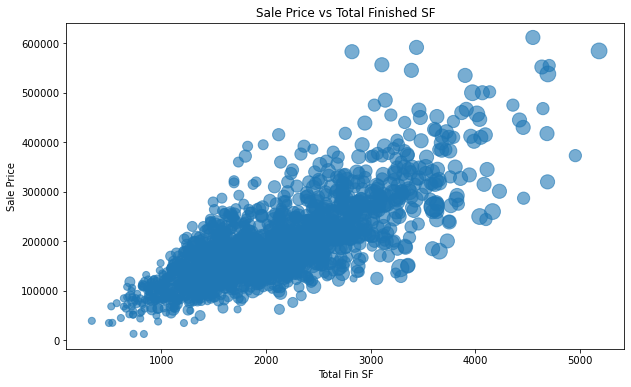

In [18]:
# Sale price vs Total sqft with numbers of bathrooms as size of scatter
plt.figure(figsize=(10,6))
# Scatter plot
plt.scatter(df['Total Fin SF'], df['SalePrice'], alpha=.6, s=df['Total Baths'] * 50)
# Create a descriptive title
plt.title('Sale Price vs Total Finished SF')

# Add axis labels
plt.xlabel('Total Fin SF')
plt.ylabel('Sale Price');
#plt.savefig('./images/Price by Total SF scatter');

NOT A SUPER EFFEECTIVE PLOT - 

In [19]:
#create sqft/dollar column
df['Dollars Per SF'] = df['SalePrice']/df['Total Fin SF']

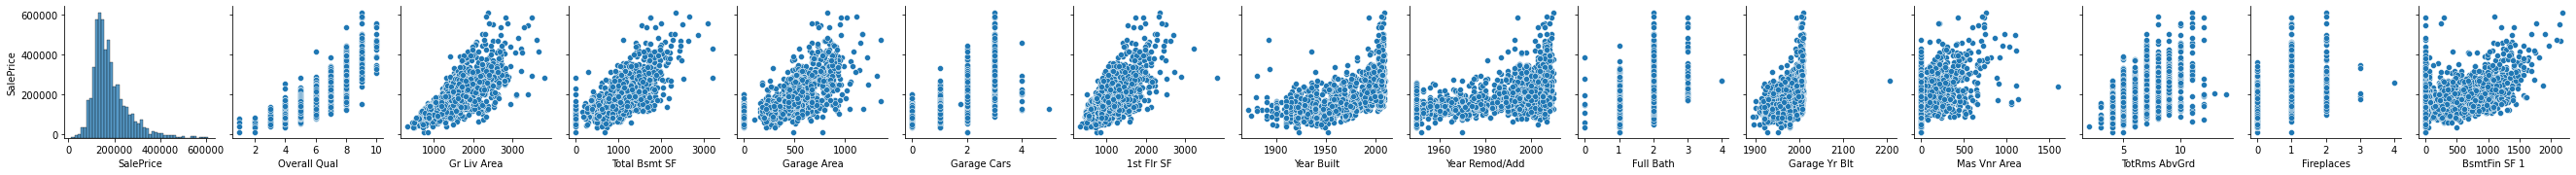

In [20]:
#pairplots of top 15 to check for correlation
sns.pairplot(df, x_vars=top_15, y_vars=['SalePrice'])
#plt.savefig('./images/pairplot top_15 corr');

In [21]:
df.corr()[['SalePrice']].sort_values(by='SalePrice',ascending=False).head(15)

,SalePrice
SalePrice,1.000000
Overall Qual,0.803462
Total Fin SF,0.765605
Gr Liv Area,0.719463
Total Bsmt SF,0.664547
Garage Area,0.655459
Garage Cars,0.648643
1st Flr SF,0.648252
Total Baths,0.612089
Year Built,0.572405


DUMMY AND MAP:


In [22]:
#map these ordinals 
obj_list_6 = ['Bsmt Cond', 'Bsmt Qual', 'Garage Cond', 'Garage Qual']
for obj in obj_list_6:
    df[f'{obj} Num'] = df[obj].map({'Ex': 5, 'Gd':4, 'TA': 3, 'Fa':2, 'Po':1, 'NA':0})

    obj_list_5 = ['Exter Cond', 'Exter Qual','Heating QC','Kitchen Qual']
for obj in obj_list_5:
    df[f'{obj} Num'] = df[obj].map({'Ex': 5, 'Gd':4, 'TA': 3, 'Fa':2, 'Po':1})    

#dummy these nominals
dum_list = ['Neighborhood', 'House Style', 'Sale Type', 'Functional']
for dum in dum_list:
    df = pd.get_dummies(df, columns = [dum], drop_first=True)
#(f'{dum}_dum') = [col for col in df.columns if 'dum' in col]

In [23]:
#save csv for iterations
#df.to_csv('./datasets/Working Data/cleaned, mapped, dummied.csv')

# MODELING

In [24]:
# Create X and y.
features = ['Overall Qual', 'Gr Liv Area', 'Exter Qual Num',
       'Kitchen Qual Num', 'Total Bsmt SF', 'Garage Area', 'Garage Cars',
       '1st Flr SF', 'Bsmt Qual Num', 'Year Built', 'Year Remod/Add',
       'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area']
# do this to add dummies? 
#X_train_dum = pd.get_dummies(X_train, columns=['day', 'month'], drop_first=True)
#or this? features.extend(neigh_dum)

X = df[features]
y = df['SalePrice']

# Instantiate 
lr = LinearRegression()

#check overall cross_val
cross_val_score(lr, X, y).mean()

0.851776836291997

In [25]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=33)
#fit
lr.fit(X_train, y_train)
#cross val train
cross_val_score(lr, X_train, y_train).mean()

0.8552281878432788

In [26]:
#train score
lr.score(X_train, y_train)

0.858718513129812

In [27]:
#test score
lr.score(X_test, y_test)

0.8405643716844815

In [28]:
pred = lr.predict(X_test)
residuals = y_test - pred

 ASSESS:
 - train score = 85.8
 - test score = 84.0
 - cross_val score = 85.5
 looks like low variance, low on bias 

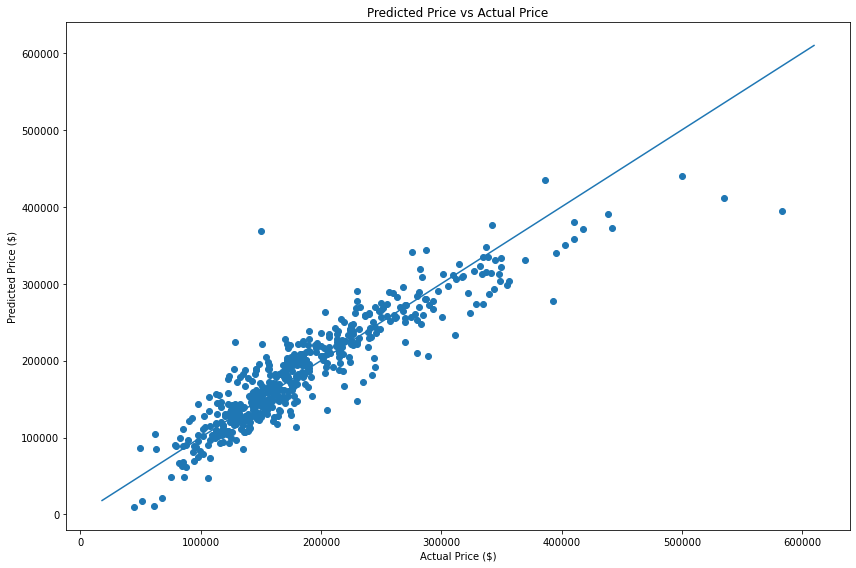

In [29]:
#Credit K Sylvia. Code given during work time with Shania Thomas
plt.figure(figsize = (12, 8))
plt.scatter(x = y_test, y = pred )
plt.title('Predicted Price vs Actual Price')
xpoints = ypoints = plt.xlim() # code borrowed from kilodalton's response on Stack Overflow
plt.plot(xpoints, ypoints)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.tight_layout();

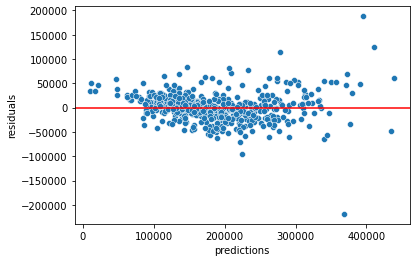

In [30]:
plt.axhline(y=0, color='r')
sns.scatterplot(x=pred, y=residuals)
('Residual Plot to Show error - Epsilon')
plt.xlabel('predictions')
plt.ylabel('residuals');

456.9929147062548

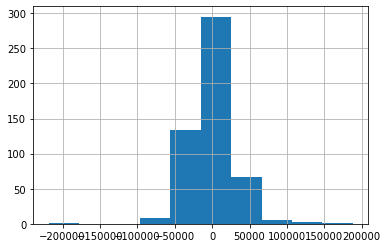

In [31]:
residuals.hist();
residuals.mean()

<AxesSubplot:>

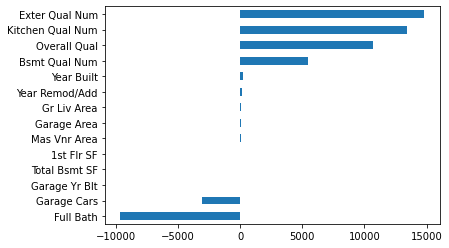

In [32]:
pd.Series(lr.coef_, index=features).sort_values().plot.barh()

In [33]:
#what's my RMSE?
np.sqrt(metrics.mean_squared_error(y_test, pred))

29891.308324090154

In [34]:
lr_coef = lr.coef_
lr_coef = pd.Series(lr_coef, X.columns)
lr_coef.sort_values(ascending=False)

Exter Qual Num      14817.380229
Kitchen Qual Num    13440.575051
Overall Qual        10680.053574
Bsmt Qual Num        5437.507757
Year Built            190.087105
Year Remod/Add        145.277658
Gr Liv Area            54.543456
Garage Area            50.450037
Mas Vnr Area           41.199760
1st Flr SF             21.418649
Total Bsmt SF          19.769878
Garage Yr Blt         -43.939543
Garage Cars         -3046.199807
Full Bath           -9685.263059
dtype: float64